In [1]:
import os
import json
import pandas as pd

# Path to the folder containing the processed data
PROCESSED_DIR = "/home/simcard/Schreibtisch/Project HEAT/city_data_parquet/processed_data_parquet"

# Dictionaries for storing data
processed_frames = {}
processed_logs = {}

# List all files in the folder
all_files = os.listdir(PROCESSED_DIR)
# Filter by JSON files, as these are the “table of contents” for the Parquets.
json_files = sorted([f for f in all_files if f.endswith('.json')])

print(f"Lade Daten aus: {PROCESSED_DIR}")
print(f"Found {len(json_files)} city data pairs.\n")

for j_file in json_files:
    # Build paths
    j_path = os.path.join(PROCESSED_DIR, j_file)
    p_path = j_path.replace('.json', '.parquet')
    
    # Load log file (JSON)
    with open(j_path, 'r') as f:
        meta = json.load(f)
    
    city_name = meta['city']
    processed_logs[city_name] = meta
    
    # Loading Parquet file
    if os.path.exists(p_path):
        df = pd.read_parquet(p_path)
        processed_frames[city_name] = df
        
        # Brief status report
        start = meta['time_frame']['start_exact'][:10] # Nur Datum
        end = meta['time_frame']['end_exact'][:10]
        vars_count = meta['variables']['count']
        
        print(f"✅ {city_name:<18} | {len(df):>7} Zeilen | {vars_count} Vars | {start} bis {end}")
    else:
        print(f"⚠️ Warning: Parquet file for {city_name} is missing!")

print(f"\n All data successfully loaded into ‘processed_frames’ and ‘processed_logs’.")

# Reduce memory consumption by approx. 50%
for city in processed_frames:
    # Convert float64 to float32
    cols = processed_frames[city].select_dtypes(include=['float64']).columns
    processed_frames[city][cols] = processed_frames[city][cols].astype('float32')

for city, df in processed_frames.items():
   print(f"\n {city}")
   print(df.dtypes)

Lade Daten aus: /home/simcard/Schreibtisch/Project HEAT/city_data_parquet/processed_data_parquet
Found 5 city data pairs.

✅ bordeaux           |  315576 Zeilen | 14 Vars | 1990-01-01 bis 2025-12-31
✅ lyon               |  315576 Zeilen | 14 Vars | 1990-01-01 bis 2025-12-31
✅ marseille          |  315576 Zeilen | 14 Vars | 1990-01-01 bis 2025-12-31
✅ marseillemarignane |  315576 Zeilen | 14 Vars | 1990-01-01 bis 2025-12-31
✅ paris              |  315576 Zeilen | 14 Vars | 1990-01-01 bis 2025-12-31

 All data successfully loaded into ‘processed_frames’ and ‘processed_logs’.

 bordeaux
timestamp                 datetime64[ns]
temperature_2m                   float32
relative_humidity_2m             float32
pressure_msl                     float32
shortwave_radiation              float32
soil_moisture_0_to_7cm           float32
wind_speed_10m                   float32
t_850hPa                         float32
t_500hPa                         float32
u_850hPa                         float32

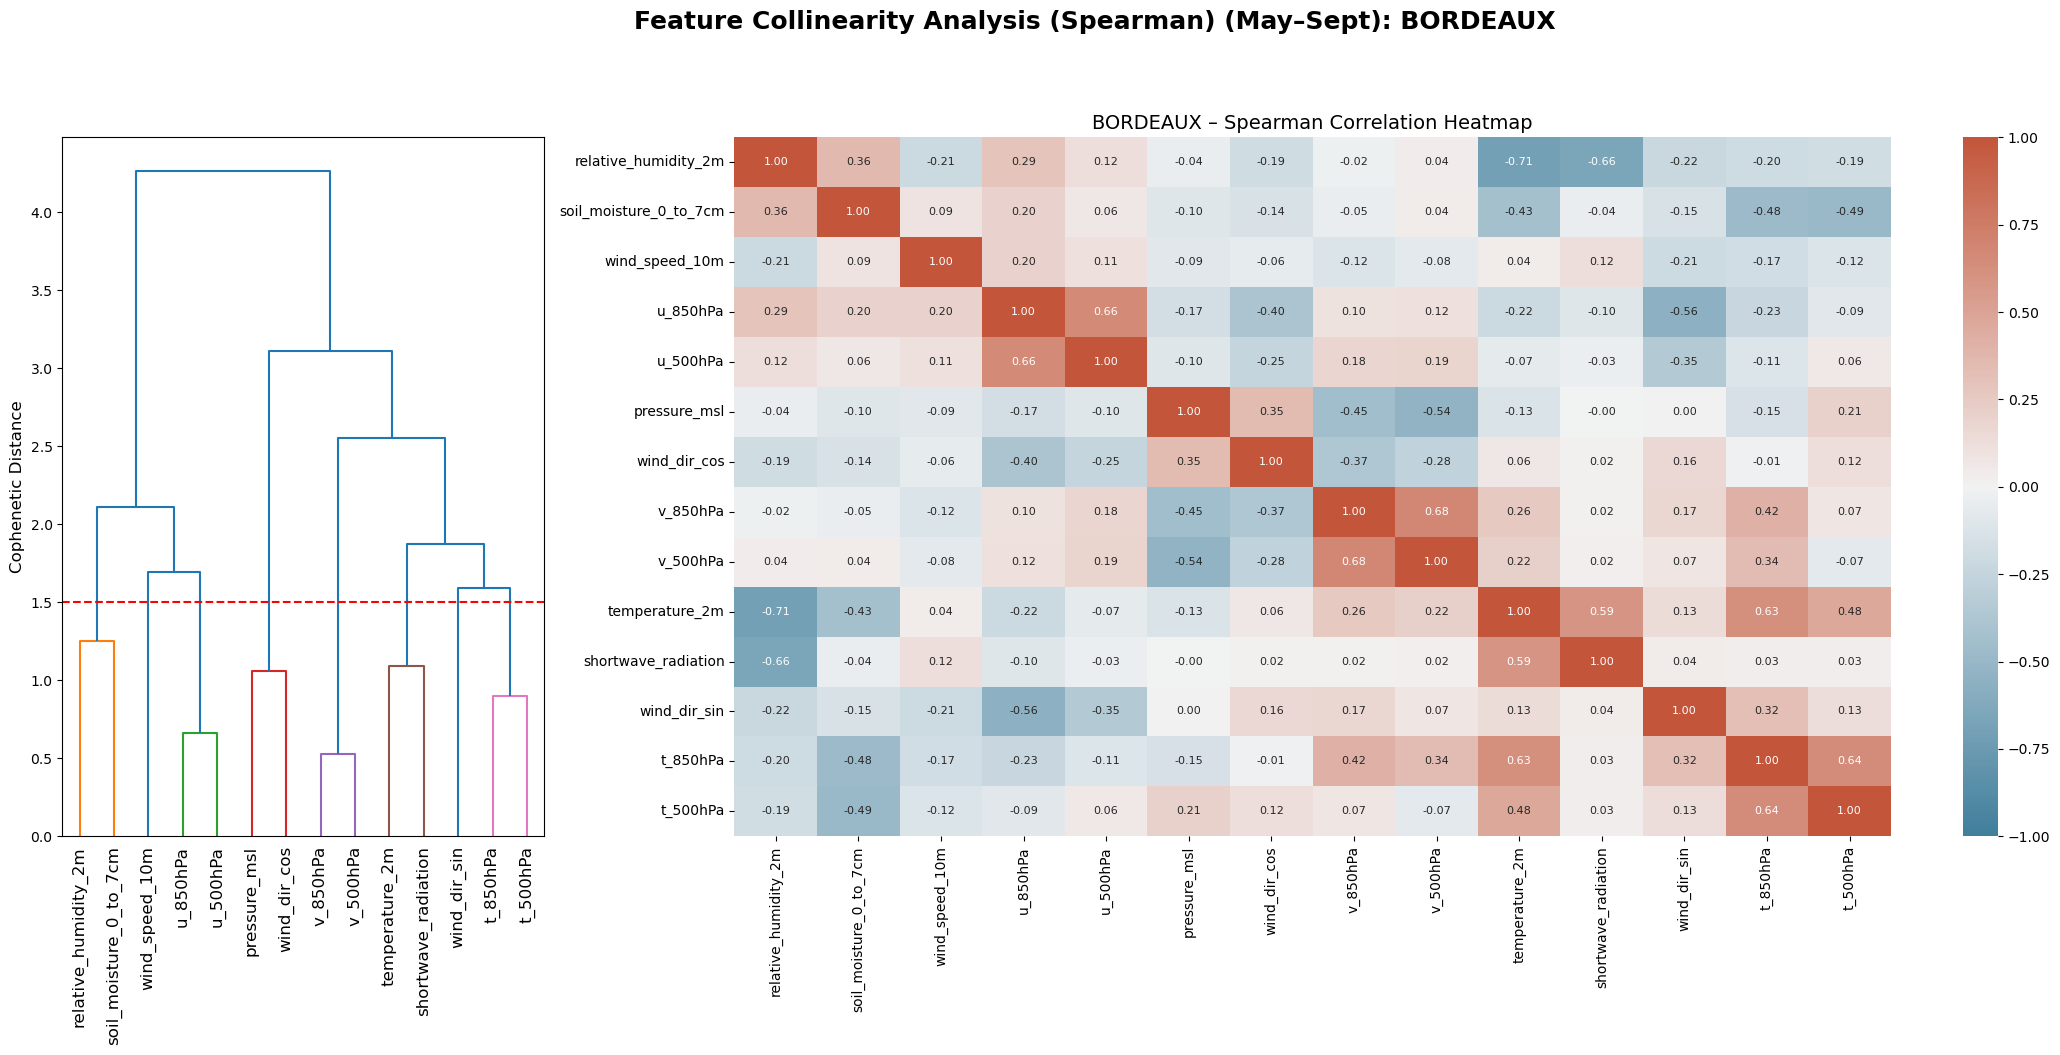

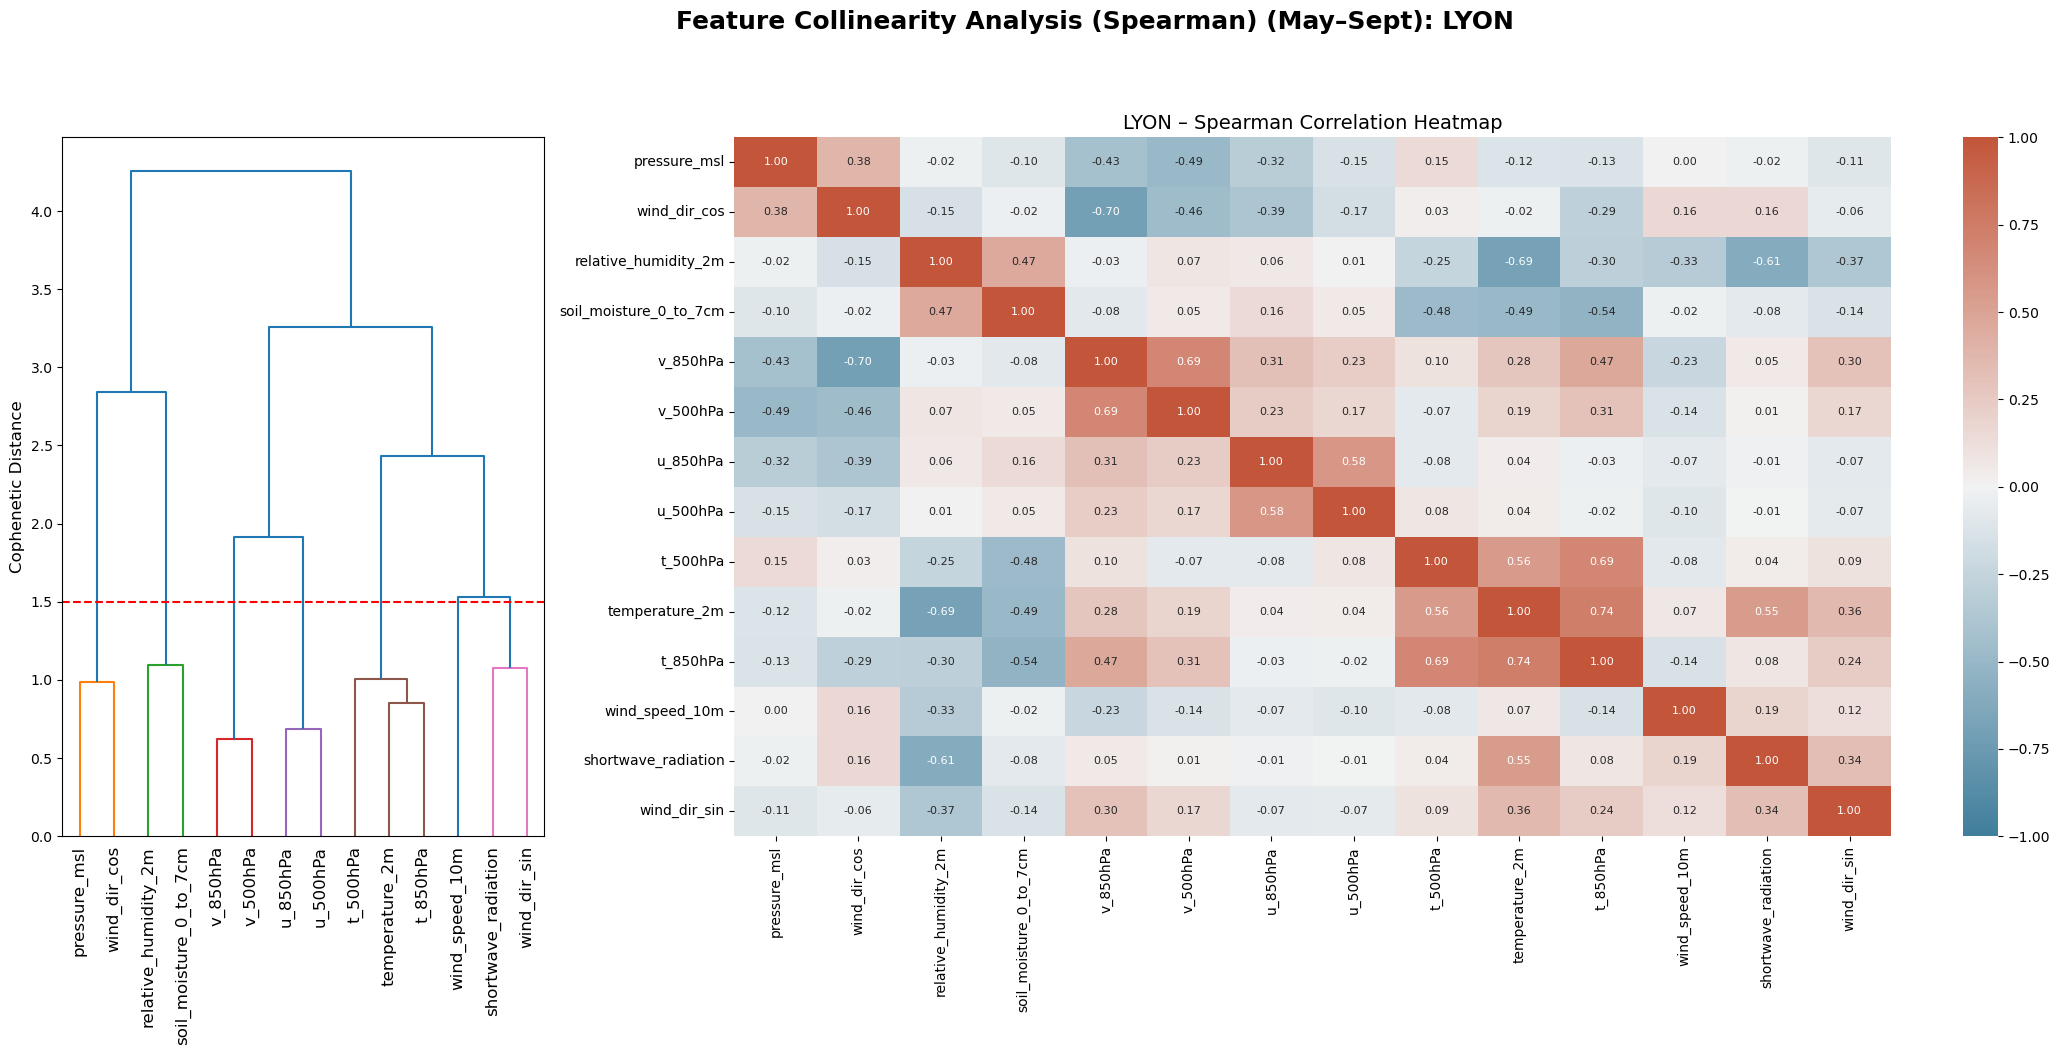

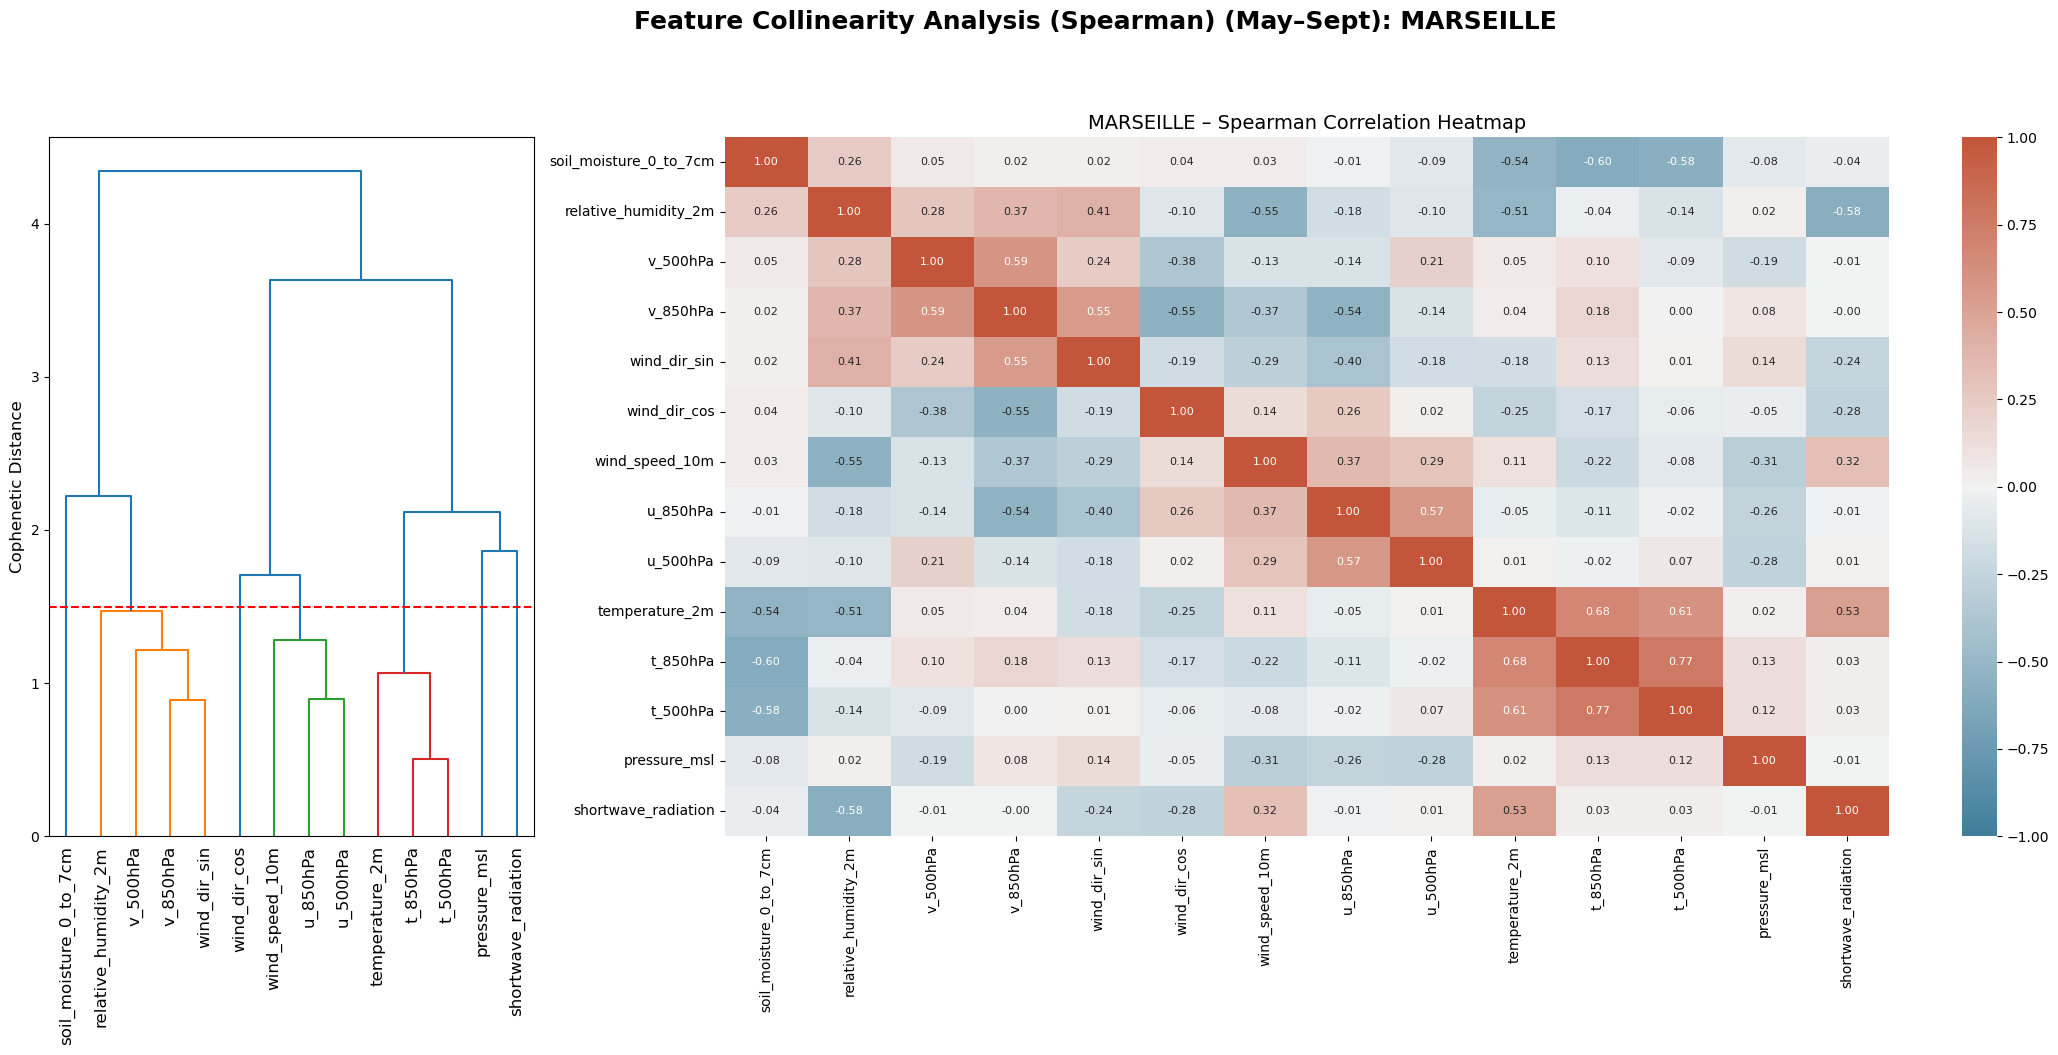

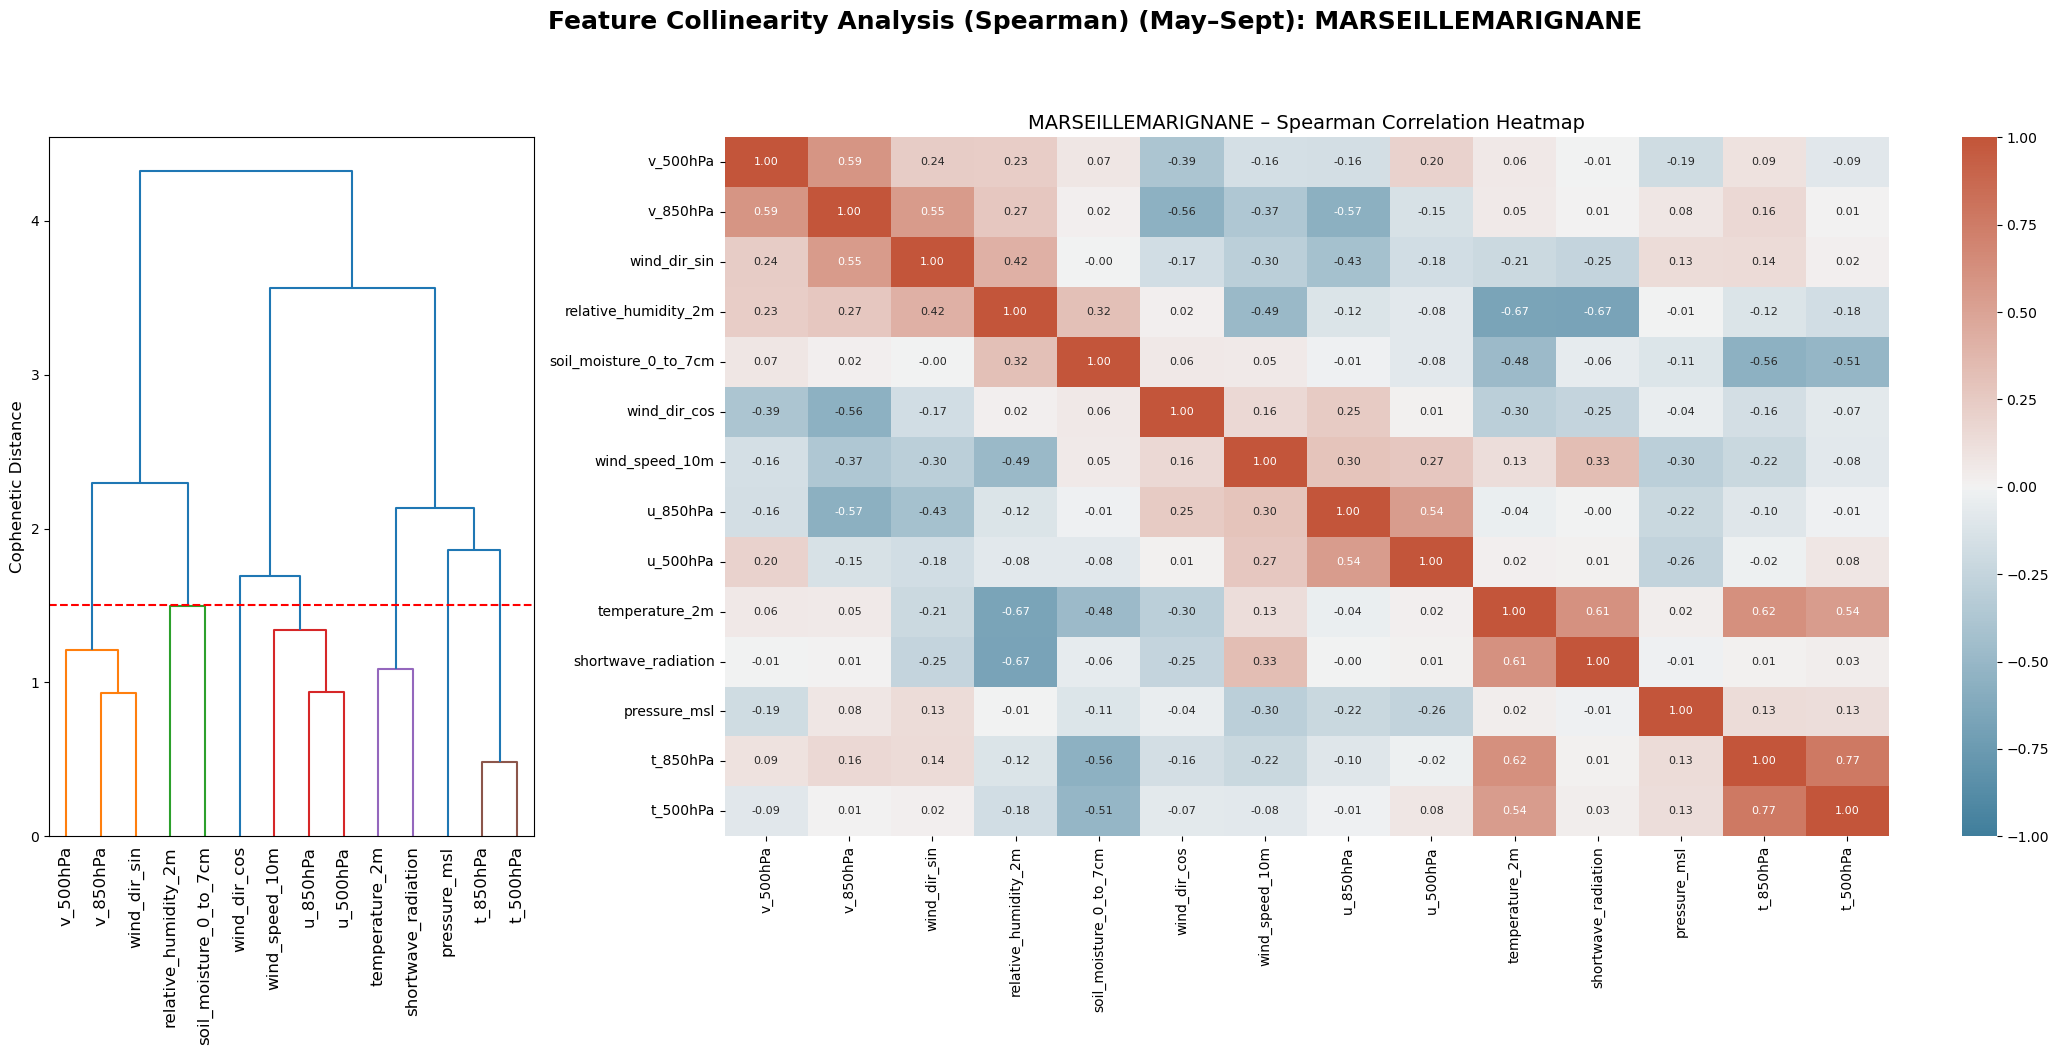

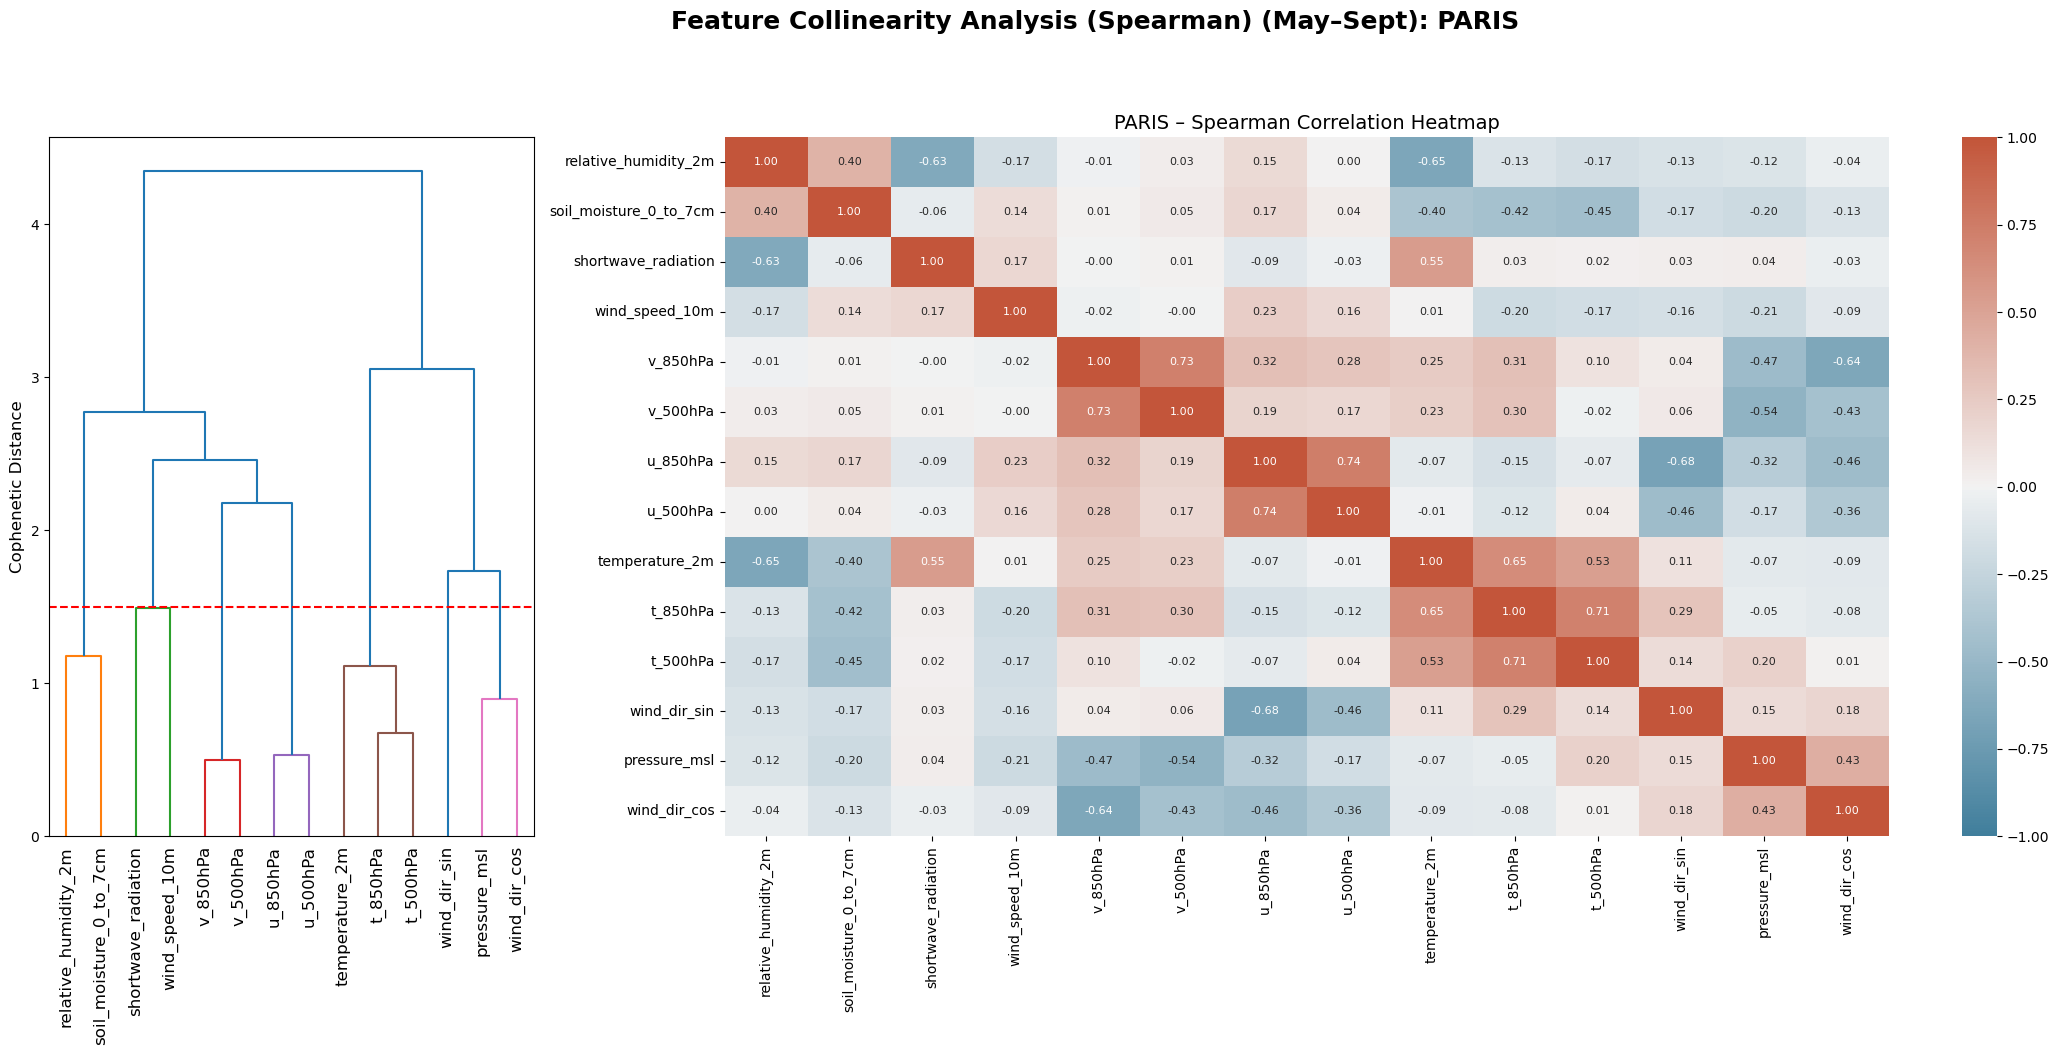

In [2]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import fcluster
import pandas as pd
import numpy as np

# Parameters for clustering
MAX_DIST = 1.5  # Threshold for color clusters in dendrogram
cmap = sns.diverging_palette(230, 20, as_cmap=True)

SUMMER_MONTHS = [5,6,7,8,9]

# Original numerical variables only (exclude timestamp, target, index)
EXCLUDED_COLS = ['timestamp', 'target_klement_event', 'index']

for city_name, df_full in processed_frames.items():
    
    # --- Filter summer months only ---
    df_summer = df_full[df_full['timestamp'].dt.month.isin(SUMMER_MONTHS)]
    
    # --- Select numerical columns only, excluding timestamp and target ---
    data_for_clustering = df_summer.select_dtypes(include=[np.number]).drop(columns=EXCLUDED_COLS, errors='ignore')
    
    # --- Compute Spearman correlation ---
    corr = data_for_clustering.corr(method='spearman').fillna(0)
    
    # --- Compute distance matrix and linkage for hierarchical clustering ---
    dist = sch.distance.pdist(corr.values)
    linkage_matrix = sch.linkage(dist, method='ward')
    
    # --- Visualization: Dendrogram + Heatmap side by side ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10), gridspec_kw={'width_ratios':[1,3]})
    fig.suptitle(f"Feature Collinearity Analysis (Spearman) (May–Sept): {city_name.upper()}", 
                 fontsize=18, fontweight='bold', y=1.05)
    
    # --- Dendrogram (left) with colored clusters ---
    dendro = sch.dendrogram(
        linkage_matrix, 
        labels=corr.columns, 
        ax=ax1, 
        leaf_rotation=90, 
        color_threshold=MAX_DIST
    )
    ax1.axhline(y=MAX_DIST, color='r', linestyle='--')  # Threshold line
    ax1.set_ylabel("Cophenetic Distance", fontsize=12)
    
    # --- Heatmap (right) sorted according to dendrogram leaves ---
    reordered_labels = [corr.columns[i] for i in dendro['leaves']]
    sns.heatmap(
        corr.loc[reordered_labels, reordered_labels], 
        annot=True, fmt=".2f", 
        cmap=cmap, 
        ax=ax2, 
        vmin=-1, vmax=1, center=0,
        annot_kws={"size": 8}
    )
    ax2.set_title(f"{city_name.upper()} – Spearman Correlation Heatmap", fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # --- Cluster assignment based on MAX_DIST ---
    cluster_labels = fcluster(linkage_matrix, MAX_DIST, criterion='distance')
    cluster_table = pd.DataFrame({'Variable': corr.columns, 'Cluster_ID': cluster_labels}).sort_values('Cluster_ID')
    

In [3]:
records = []
for city_name, df in processed_frames.items():
    df_daily_max = df.resample('D', on='timestamp')['temperature_2m'].max()
    temp_p95     = df_daily_max.quantile(0.95)
    over_p95     = df_daily_max > temp_p95
    group_id     = (over_p95 != over_p95.shift()).cumsum()

    for gid, group in over_p95.groupby(group_id):
        if group.all() and len(group) >= 3:
            records.append({
                "City":            city_name,
                "Start_Date":      group.index[0],
                "Duration_days":   len(group),
                "P95_temperature": temp_p95
            })

heatwave_starts = pd.DataFrame(records)
heatwave_starts.sort_values(by=["City", "Start_Date"], inplace=True)
heatwave_starts.reset_index(drop=True, inplace=True)

city_counts = heatwave_starts.groupby('City').size()
print(city_counts)
print(f"\nGesamt: {len(heatwave_starts)} Events")

City
bordeaux              80
lyon                  84
marseille             77
marseillemarignane    82
paris                 84
dtype: int64

Gesamt: 407 Events


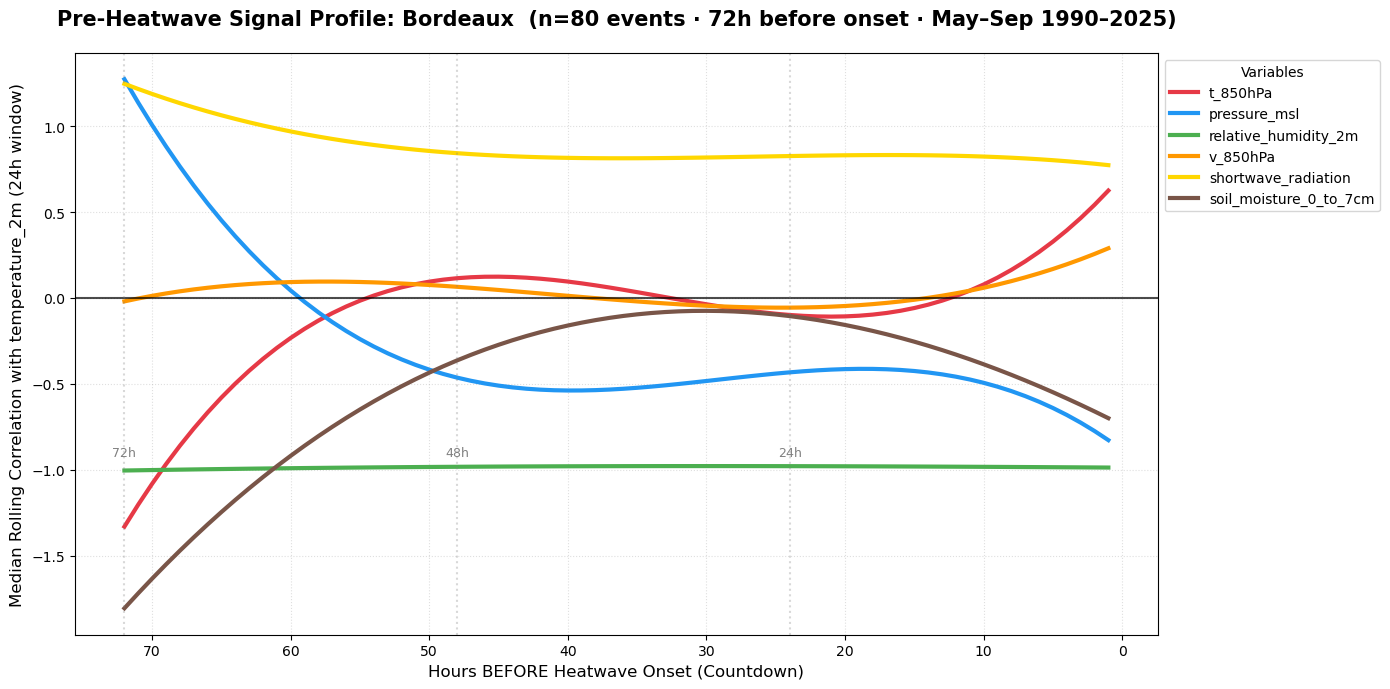

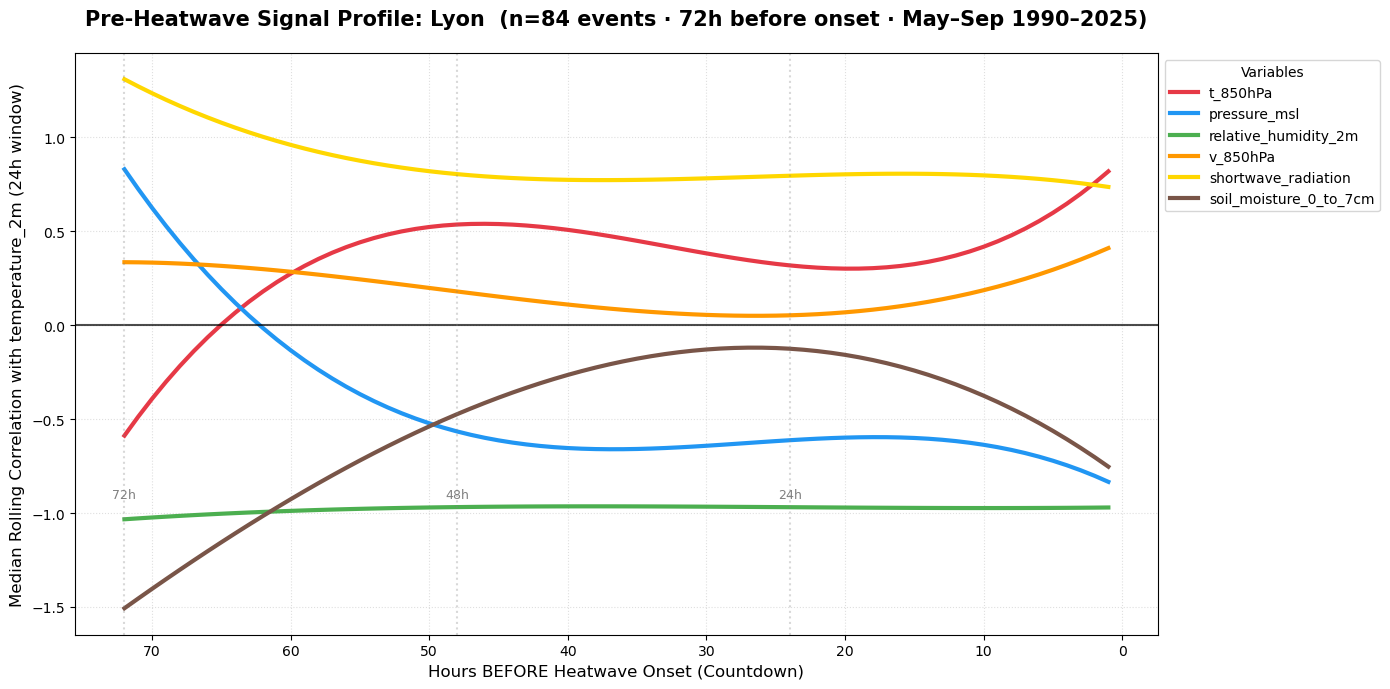

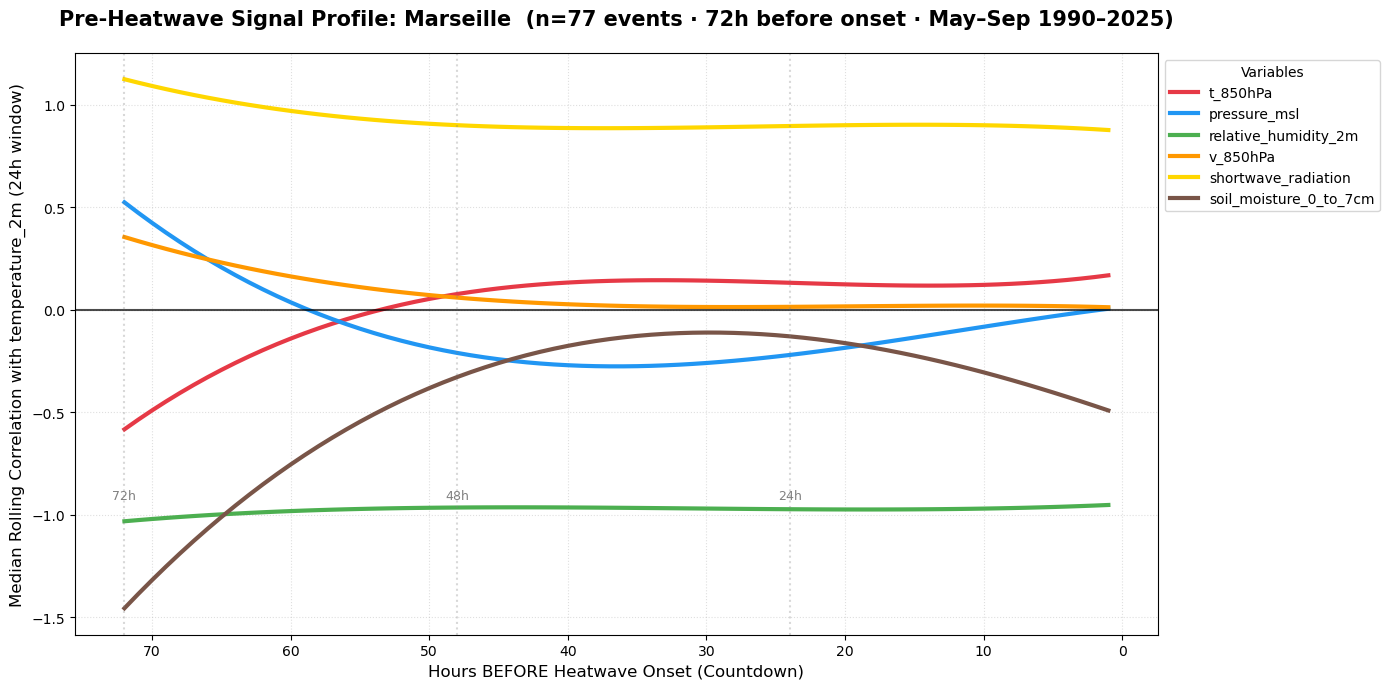

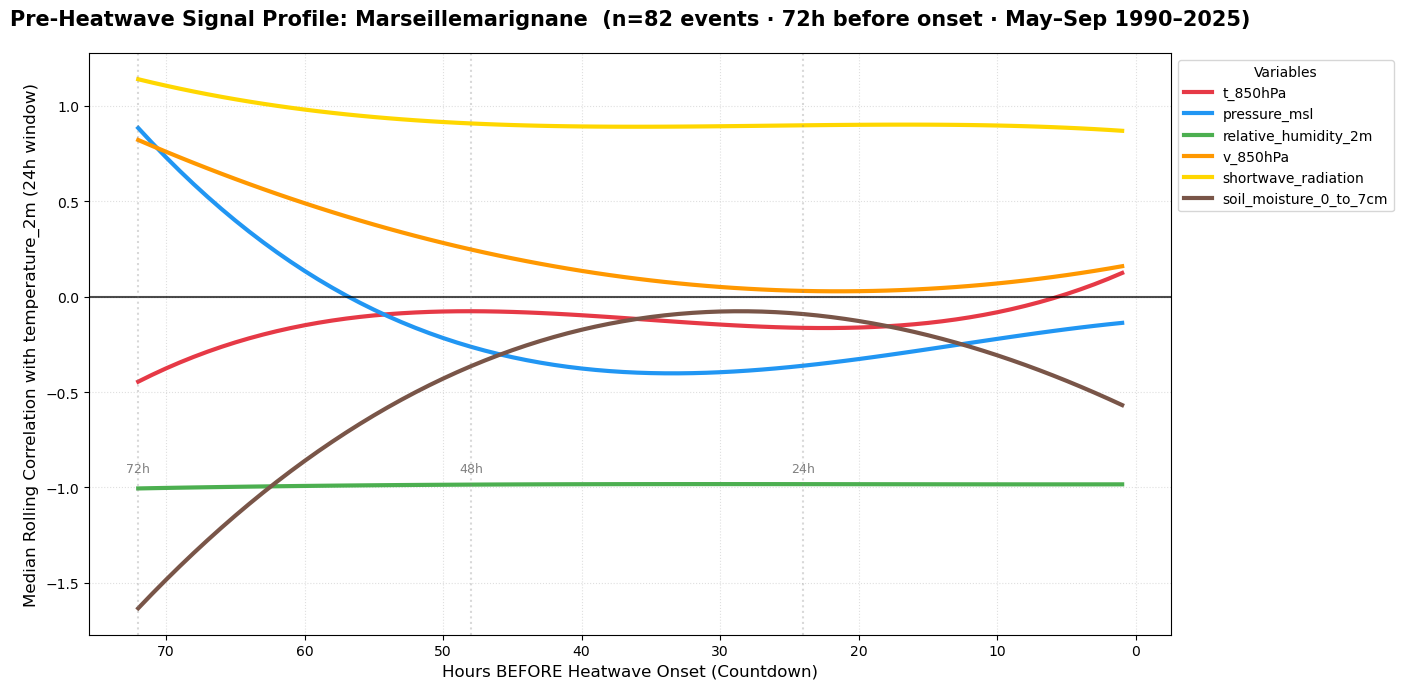

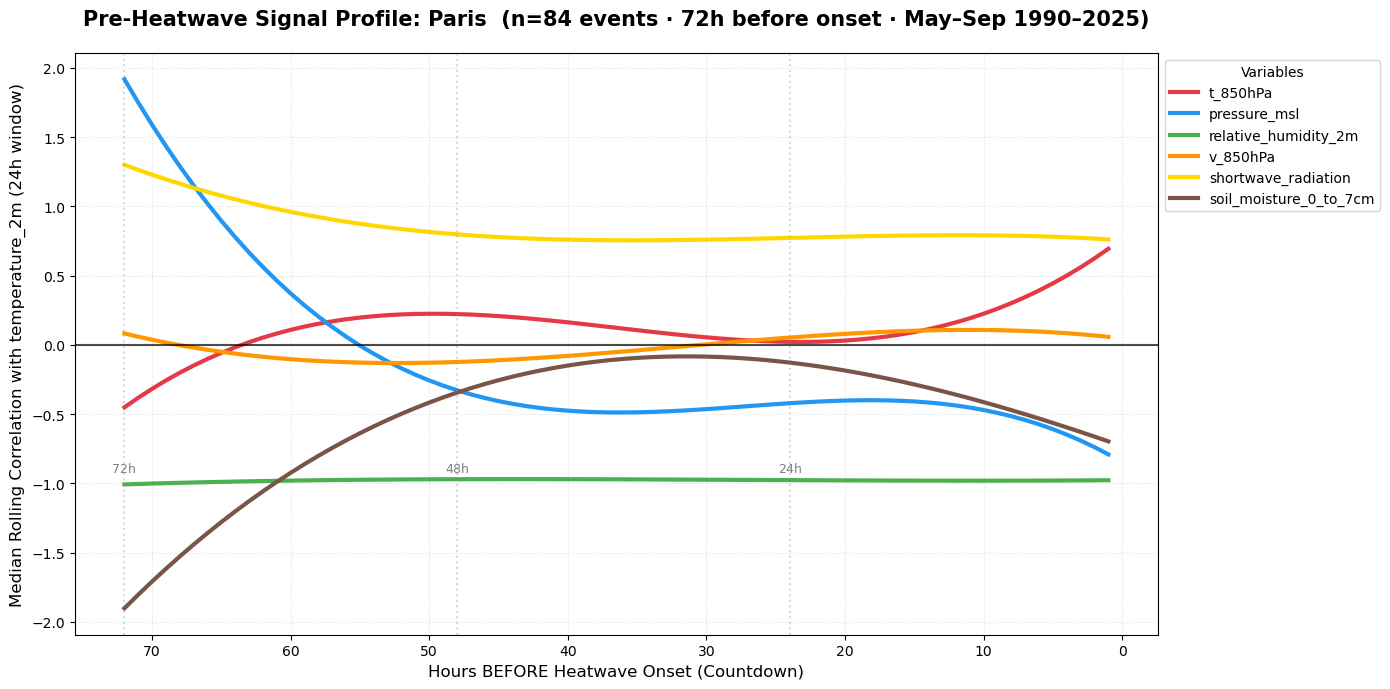

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# CONFIGURATION
# ============================================================
POLY_DEGREE = 3
HOURS_BEFORE = 72

selected_focus_graph = [
    't_850hPa',
    'pressure_msl',
    'relative_humidity_2m',
    'v_850hPa',
    'shortwave_radiation',
    'soil_moisture_0_to_7cm'
]

VAR_COLORS = {
    't_850hPa':               '#e63946',  # Red
    'pressure_msl':           '#2196F3',  # Blue
    'relative_humidity_2m':   '#4CAF50',  # Green
    'v_850hPa':               '#FF9800',  # Orange
    'shortwave_radiation':    '#FFD700',  # Gold
    'soil_moisture_0_to_7cm': '#795548',  # Brown
}

# ============================================================
# LOOP OVER ALL CITIES
# ============================================================
import warnings


for city_name, df_full in processed_frames.items():
    clean_name   = city_name.replace('_', ' ').title()
    city_events  = heatwave_starts[heatwave_starts['City'] == city_name]

    if city_events.empty:
        print(f"⚠️ No events for {clean_name}, skipping.")
        continue

    df = df_full.copy()
    df = df[(df['timestamp'].dt.month >= 5) & (df['timestamp'].dt.month <= 9)]

    all_features      = [c for c in df.select_dtypes(include=[np.number]).columns
                         if c != 'temperature_2m']
    hour_offsets      = list(range(-HOURS_BEFORE, 0))
    all_event_results = {feat: [] for feat in all_features}

    for _, event_row in city_events.iterrows():
        heatwave_start = pd.Timestamp(event_row['Start_Date'])
        window_start   = heatwave_start - pd.Timedelta(hours=HOURS_BEFORE)

        df_window = df[
            (df['timestamp'] >= window_start) &
            (df['timestamp'] <  heatwave_start)
        ].copy().reset_index(drop=True)

        if len(df_window) < 12:
            continue

        for feat in all_features:
            if feat not in df_window.columns:
                continue
            roll = (
                df_window[['temperature_2m', feat]]
                .rolling(window=24, min_periods=12)
                .corr()
                .xs('temperature_2m', level=1)[feat]
                .values
            )
            all_event_results[feat].append(roll)

    # Median over all events
    results = pd.DataFrame(index=hour_offsets, columns=all_features, dtype=float)
    for feat in all_features:
        series_list = all_event_results[feat]
        if not series_list:
            continue
        padded = np.full((len(series_list), HOURS_BEFORE), np.nan)
        for i, s in enumerate(series_list):
            s = np.array(s, dtype=float)
            if len(s) >= HOURS_BEFORE:
                padded[i] = s[-HOURS_BEFORE:]
            else:
                padded[i, -len(s):] = s
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", RuntimeWarning)
            results[feat] = np.nanmedian(padded, axis=0)

    # ============================================================
    # VISUALIZATION
    # ============================================================
    plt.figure(figsize=(14, 7))

    x             = np.abs(np.array(hour_offsets))  # 72 → 1 countdown
    plot_features = [f for f in selected_focus_graph if f in results.columns]

    for feat in plot_features:
        col  = VAR_COLORS[feat]
        y    = results[feat].values.astype(float)
        mask = ~np.isnan(y)


        # Smoothed trend
        if mask.sum() > POLY_DEGREE:
            z = np.polyfit(x[mask], y[mask], POLY_DEGREE)
            p = np.poly1d(z)
            plt.plot(x, p(x), color=col, linestyle='-', linewidth=3, label=feat)

    n_events = len(city_events)
    plt.title(
        f"Pre-Heatwave Signal Profile: {clean_name}  "
        f"(n={n_events} events · 72h before onset · May–Sep 1990–2025)",
        fontsize=15, fontweight='bold', pad=20
    )
    plt.xlabel("Hours BEFORE Heatwave Onset (Countdown)", fontsize=12)
    plt.ylabel("Median Rolling Correlation with temperature_2m (24h window)", fontsize=12)

    plt.gca().invert_xaxis()
    plt.axhline(0, color='black', alpha=0.7, linewidth=1.5)

    for h in [24, 48, 72]:
        plt.axvline(h, color='gray', alpha=0.3, linestyle=':')
        plt.text(h, -0.92, f'{h}h', color='gray', fontsize=9, ha='center')

    plt.grid(True, linestyle=':', alpha=0.4)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1),
               fontsize='medium', frameon=True, title='Variables')
    plt.tight_layout()
    plt.show()
